## 数据分布偏移的类型总结

| 类型              | 含义说明                                                       | 概率分解公式                     | 典型表现                                                     | 检测方法                                                                 | 应对策略                                                                 |
|-------------------|----------------------------------------------------------------|----------------------------------|----------------------------------------------------------------|--------------------------------------------------------------------------|--------------------------------------------------------------------------|
| Covariate shift   | 特征分布 `P(X)` 发生变化，条件分布 `P(Y|X)` 保持不变           | `P(X, Y) = P(Y|X) * P(X)`        | 测试集与训练集的输入特征分布不同，模型泛化性能下降             | 训练 domain classifier；KS 检验；PCA 可视化对比分布                     | 样本重加权（importance weighting）；特征对齐；领域自适应（domain adaptation） |
| Label shift       | 标签分布 `P(Y)` 发生变化，类条件分布 `P(X|Y)` 保持不变          | `P(X, Y) = P(X|Y) * P(Y)`        | 测试集中标签比例发生变化（如某些类别比例上升/下降）             | 比较训练/测试标签分布；EM 算法估计标签先验 `P(Y)`                       | 类权重校正（class prior correction）；温度缩放；调整决策阈值             |
| Concept drift     | 条件分布 `P(Y|X)` 发生变化           | `P(X, Y) = P(Y|X) * P(X)`        | 随时间推移，模型性能突降，表示数据的决策边界发生了变化         | 连续监控模型性能（如 F1、AUC）；滑动窗口验证集；漂移检测方法           | 在线学习；模型更新（如 EWA）；集成方法（如 DWM）；周期性重训练         |

Note：在真实任务中，`P(X)` 的变化往往也会间接引发 `P(Y)` 的变化，因此 Covariate Shift 有时也会导致 Label Shift。实际分析中应综合模型性能、标签分布和特征分布共同判断。

| 类型              | 方法/策略                      | 代表文献                                                  |
|-------------------|--------------------------------|-----------------------------------------------------------|
| Covariate Shift   | Importance Weighting           | [Shimodaira (2000)](https://scholar.google.com/scholar?q=Improving+predictive+inference+under+covariate+shift+by+weighting+the+log-likelihood+function) |
|                   | Kernel Mean Matching (KMM)     | [Huang et al. (2007)](https://scholar.google.com/scholar?q=Correcting+sample+selection+bias+by+unlabeled+data) |
|                   | Domain Classifier Detection    | [Sugiyama et al. (2007)](https://scholar.google.com/scholar?q=Covariate+shift+adaptation+by+importance+weighted+cross+validation) |
|                   | MMD / KS 检验                  | [Gretton et al. (2012)](https://scholar.google.com/scholar?q=A+kernel+two-sample+test) |
|                   | Adversarial Adaptation (DANN)  | [Ganin et al. (2016)](https://scholar.google.com/scholar?q=Domain-adversarial+training+of+neural+networks) |
| Label Shift        | Class Prior Estimation (EM)    | [Saerens et al. (2002)](https://scholar.google.com/scholar?q=Adjusting+the+outputs+of+a+classifier+to+new+a+priori+probabilities:+A+simple+procedure) |
|                    | Label Shift Detection          | [Lipton et al. (2018)](https://scholar.google.com/scholar?q=Detecting+and+correcting+for+label+shift+with+black+box+predictors) |
|                    | Temperature Scaling            | [Guo et al. (2017)](https://scholar.google.com/scholar?q=On+calibration+of+modern+neural+networks) |
| Concept Drift      | Drift Detection Method (DDM)   | [Baena-García et al. (2006)](https://scholar.google.com/scholar?q=Early+drift+detection+method) |
|                    | Sliding Window Evaluation      | [Gama et al. (2014)](https://scholar.google.com/scholar?q=A+survey+on+concept+drift+adaptation) |
|                    | Ensemble for Drift (DWM)       | [Kolter & Maloof (2007)](https://scholar.google.com/scholar?q=Dynamic+weighted+majority:+An+ensemble+method+for+drifting+concepts) |
|                    | Online Learning + EWA          | [Cesa-Bianchi & Lugosi (2006)](https://scholar.google.com/scholar?q=Prediction,+Learning,+and+Games) |



## 问题

问题1：协变量偏移 和 概念便宜是否互斥？

“可能共存”？现实世界数据复杂，`P(X)` 变化很容易导致 `P(Y|X)` 也变化（比如数据分布变了，边界就不一样了）；所以在实际中观察模型性能下降，很难分清楚到底是 shift 了 `X`，还是 drift 了 `Y|X`。

问题2：为什么后续 Concept Drift 分析建议使用 feat_merged（Top-K 特征）而不是全部特征？

关注模型关注的部分：并不是所有特征对模型预测都有影响。即便某些特征发生了分布漂移，但若它们对模型预测不重要，那对最终结果影响就小。我们更应检测的是模型真正依赖的特征的 `P(X)` 是否变了。

## 协变量偏移

### KS 双样本检验的理论依据（用于评估协变量偏移）

**Kolmogorov–Smirnov (KS) 两样本检验**是一种非参数统计方法，用于判断两个样本是否来自**同一分布**。在机器学习中，它常用于检测训练集与测试集在某一特征维度上的**协变量分布差异（Covariate Shift）**。

#### 检验假设

- **原假设（Null Hypothesis）**：  
  $$
  P_{\text{train}}(X) = P_{\text{test}}(X)
  $$
  表示该特征在训练集和测试集中的分布一致。

- **备择假设（Alternative Hypothesis）**：  
  $$
  P_{\text{train}}(X) \ne P_{\text{test}}(X)
  $$
  表示该特征在训练集和测试集中的分布不同，可能存在协变量偏移。

#### 检验统计量

KS检验的核心统计量 $D$ 定义如下：
$$
D = \sup_x \left| F_n(x) - G_m(x) \right|
$$

其中：
- $F_n(x)$ 是训练集在某一特征维度上的经验分布函数（Empirical CDF）；
- $G_m(x)$ 是测试集在该特征维度上的经验分布函数；
- $\sup$ 表示在所有 $x$ 上的最大绝对差异。


#### p 值解释

- 若 **p < 0.05**（通常设定的显著性水平），则有统计证据拒绝原假设；
- 可推断该特征在训练集与测试集之间存在**显著分布差异**，说明该特征可能发生了 **Covariate Shift**。



In [11]:
import pandas as pd
from scipy.stats import ks_2samp

X_train = pd.read_csv("../data/X_train.csv", skiprows=1, header=None)
X_test = pd.read_csv("../data/X_test_2.csv", skiprows=1, header=None).iloc[:202]  # 仅取有标签部分

# 逐列进行 KS 检验
ks_results = []
for i in range(X_train.shape[1]):
    train_col = X_train.iloc[:, i]
    test_col = X_test.iloc[:, i]
    stat, p_val = ks_2samp(train_col, test_col)
    ks_results.append((i, stat, p_val))

ks_df = pd.DataFrame(ks_results, columns=["feature_idx", "ks_stat", "p_value"])
ks_df["significant"] = ks_df["p_value"] < 0.05

# 输出偏移统计结果
n_shifted = ks_df["significant"].sum()
total = len(ks_df)
print(f"共有 {n_shifted}/{total} 个特征存在显著分布偏移 (p < 0.05)，占比 {n_shifted/total:.2%}")

ks_df_sorted = ks_df.sort_values(by="ks_stat", ascending=False)
ks_df_sorted


共有 190/300 个特征存在显著分布偏移 (p < 0.05)，占比 63.33%


,feature_idx,ks_stat,p_value,significant
249,249,0.347976,6.404787e-22,True
90,90,0.341781,3.835617e-21,True
141,141,0.312378,1.165150e-17,True
46,46,0.303373,1.161600e-16,True
270,270,0.292970,1.510417e-15,True
...,...,...,...,...
275,275,0.037630,9.315890e-01,False
183,183,0.037441,9.340482e-01,False
256,256,0.035712,9.543311e-01,False
192,192,0.035173,9.597347e-01,False


In [30]:
import pandas as pd
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import seaborn as sns

X_train = pd.read_csv("../data/X_train.csv", skiprows=1, header=None)
X_test = pd.read_csv("../data/X_test_1.csv", skiprows=1, header=None).iloc[:202]  # 仅取有标签部分

# 逐列进行 KS 检验
ks_results = []
for i in range(X_train.shape[1]):
    train_col = X_train.iloc[:, i]
    test_col = X_test.iloc[:, i]
    stat, p_val = ks_2samp(train_col, test_col)
    ks_results.append((i, stat, p_val))

ks_df = pd.DataFrame(ks_results, columns=["feature_idx", "ks_stat", "p_value"])
ks_df["significant"] = ks_df["p_value"] < 0.05

# 输出偏移统计结果
n_shifted = ks_df["significant"].sum()
total = len(ks_df)
print(f"共有 {n_shifted}/{total} 个特征存在显著分布偏移 (p < 0.05)，占比 {n_shifted/total:.2%}")

ks_df_sorted = ks_df.sort_values(by="ks_stat", ascending=False)
ks_df_sorted


共有 36/300 个特征存在显著分布偏移 (p < 0.05)，占比 12.00%


,feature_idx,ks_stat,p_value,significant
106,106,0.123671,0.004246,True
85,85,0.122173,0.004922,True
101,101,0.116464,0.008500,True
6,6,0.115998,0.008881,True
29,29,0.115211,0.009551,True
...,...,...,...,...
53,53,0.033731,0.972179,False
142,142,0.032130,0.982670,False
202,202,0.031672,0.985075,False
281,281,0.031462,0.986098,False


C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train.iloc[:, idx], label="Train", shade=True)
C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test.iloc[:, idx], label="Test", shade=True)


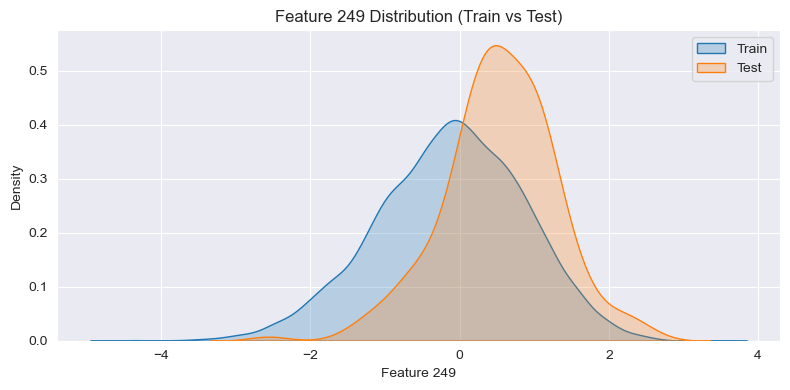

C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train.iloc[:, idx], label="Train", shade=True)
C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test.iloc[:, idx], label="Test", shade=True)


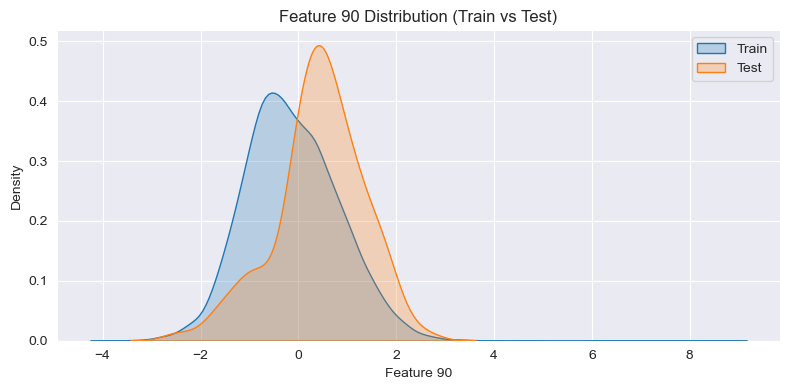

C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train.iloc[:, idx], label="Train", shade=True)
C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test.iloc[:, idx], label="Test", shade=True)


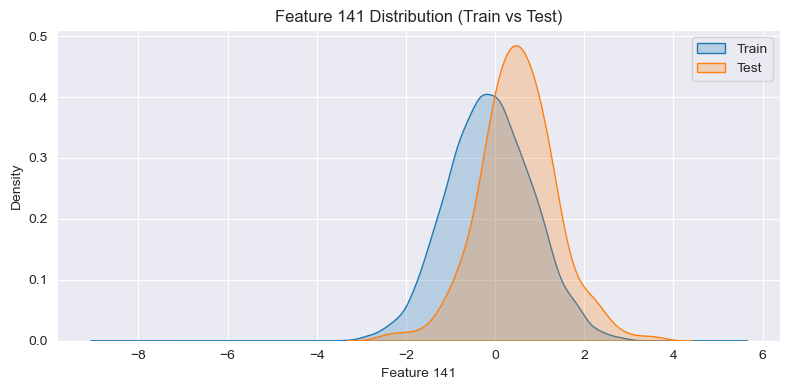

C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train.iloc[:, idx], label="Train", shade=True)
C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test.iloc[:, idx], label="Test", shade=True)


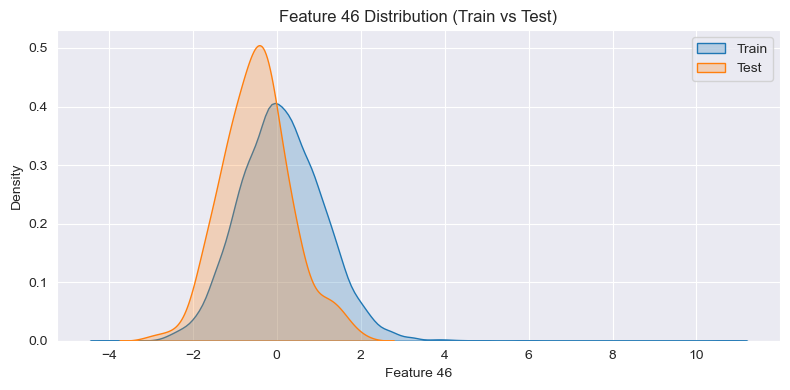

C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_train.iloc[:, idx], label="Train", shade=True)
C:\Users\dedsec\AppData\Local\Temp\ipykernel_50092\4106140484.py:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(X_test.iloc[:, idx], label="Test", shade=True)


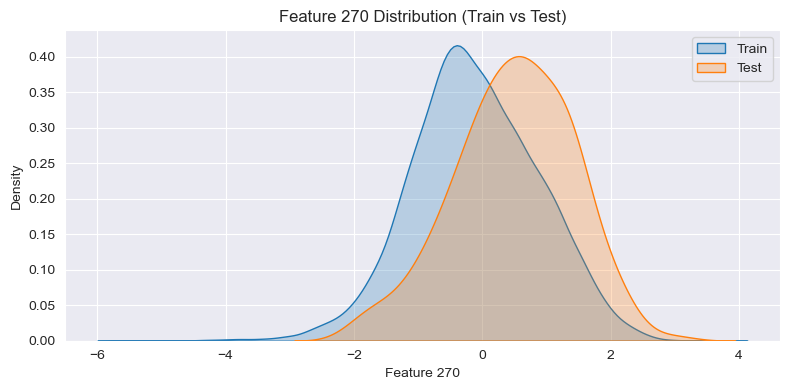

In [12]:
# 可视化前几个偏移最大的特征
top_shifted = ks_df.sort_values(by="ks_stat", ascending=False).head(5)["feature_idx"].values

for idx in top_shifted:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(X_train.iloc[:, idx], label="Train", shade=True)
    sns.kdeplot(X_test.iloc[:, idx], label="Test", shade=True)
    plt.title(f"Feature {idx} Distribution (Train vs Test)")
    plt.xlabel(f"Feature {idx}")
    plt.legend()
    plt.tight_layout()
    plt.show()

300 个特征，其中 190 个特征在训练集与测试集之间的分布存在显著性差异（p < 0.05），占比高达 63.33%；

但是 我们只能够确定 `P(X)` 在训练集和测试集之间发生了显著变化

那 `P(Y|X)` 是否变化了呢？

我们还得进一步分析

## 概念漂移

判断 `P(Y|X)` 是否稳定，虽然不能直接观测 `P(Y|X)`，但可以通过间接方法评估模型是否在不同集上泛化失效，如下：

- 模型性能对比：如果模型在训练集（交叉验证）上性能良好，但在测试集表现显著下降；并且这种下降并非由 `P(X)` 的变化直接引起（已控制 covariate shift 后依旧失效），则可以推断 `P(Y|X)` 发生变化。

- 类别召回率下降：多个类别在测试集上出现系统性漏检，可能说明边界漂移。


### 模型在训练集和测试集上的泛化能力比较（固定特征）

如果模型在交叉验证中表现良好，但在 Test2（前202）上明显下降，并且我们已知 `P(X)` 变化不能完全解释这个下降，那就有可能是 `P(Y|X)` 变了。

In [15]:
import pandas as pd

# 读取重要性融合排序结果（feat_merged）
feat_merged = pd.read_csv("../result/feat_merged.csv")

# 取前 K 个重要特征
top_k = 190
top_feats = feat_merged.head(top_k).copy()

# 合并 KS 检验结果
top_feats_ks = pd.merge(top_feats, ks_df_sorted, on="feature_idx", how="left")

# 在 Top-K 中筛选出发生显著偏移的特征（p < 0.05）
shifted_top_feats = top_feats_ks[top_feats_ks["p_value"] < 0.05].copy()
shifted_top_feats = shifted_top_feats.sort_values(by="ks_stat", ascending=False)

print(f"在前 {top_k} 个重要特征中，共有 {len(shifted_top_feats)} 个发生显著分布偏移 (p < 0.05)")

在前 190 个重要特征中，共有 138 个发生显著分布偏移 (p < 0.05)


若在 validation 上表现良好，而在 Test2 上大幅下降，则说明模型训练时的假设（`P(Y|X)` 不变）不成立，存在 Concept Drift。

若性能下降幅度小，可认为偏移主要集中在 `P(X)`，而 `P(Y|X)` 基本不变。


In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, f1_score
from xgboost import XGBClassifier
from scipy.stats import ks_2samp

# === Step 1: Load data ===
X_train_all = pd.read_csv("../data/X_train.csv", skiprows=1, header=None)
y_train_raw = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()
X_test_all = pd.read_csv("../data/X_test_2.csv", skiprows=1, header=None).iloc[:202]
y_test_raw = pd.read_csv("../data/y_test_2_reduced.csv", skiprows=1, header=None).values.ravel()

# === Step 2: Label encoding ===
le = LabelEncoder()
y_train = le.fit_transform(y_train_raw)
y_test = le.transform(y_test_raw)

# === Step 3: Load feature importance (feat_merged) and run KS test ===
feat_merged = pd.read_csv("../result/feat_merged.csv")  # 确保该文件存在
top_k = 190
top_feats = feat_merged.head(top_k).copy()

# 选出发生显著偏移的特征
shifted_top_feats = ks_df[ks_df["p_value"] < 0.05].sort_values(by="ks_stat", ascending=False)
selected_feats = shifted_top_feats["feature_idx"].astype(int).tolist()

# === Step 4: Subset & Split ===
X_train = X_train_all.iloc[:, selected_feats]
X_test = X_test_all.iloc[:, selected_feats]

# 拆分出验证集
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=42
)

# === Step 5: Standardize ===
scaler = StandardScaler()
X_subtrain_std = scaler.fit_transform(X_subtrain)
X_val_std = scaler.transform(X_val)
X_test_std = scaler.transform(X_test)

# === Step 6: Train model ===
model = XGBClassifier(
    objective="multi:softprob",
    num_class=28,
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
model.fit(X_subtrain_std, y_subtrain)

# === Step 7: Evaluation ===
# --- Validation set ---
y_val_pred = model.predict(X_val_std)
f1_val = f1_score(y_val, y_val_pred, average="weighted")
print("Validation Set Performance")
print("Weighted F1:", f1_val)
print(classification_report(y_val, y_val_pred, zero_division=0))

# --- Test2 set ---
y_test_pred = model.predict(X_test_std)
f1_test = f1_score(y_test, y_test_pred, average="weighted")
print("\nTest2 Set Performance")
print("Weighted F1:", f1_test)
print(classification_report(y_test, y_test_pred, zero_division=0))


E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:42:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation Set Performance
Weighted F1: 0.7140272326215281
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         1
           3       0.33      0.08      0.12        13
           4       0.51      0.42      0.46        48
           5       0.88      0.98      0.92       896
           6       0.86      0.88      0.87       111
           7       0.60      0.29      0.39        21
           8       0.64      0.72      0.68       103
           9       0.00      0.00      0.00         5
          10       0.69      0.88      0.78       216
          11       0.60      0.38      0.46        16
          12       0.41      0.48      0.44        91
          13       0.00      0.00      0.00        12
          14       0.25      0.02      0.04        53
          15       0.80      0.80      0.80         5
          16       0.0

我们在固定特征集合（前190个Top-K特征中显著分布偏移的138个）下，训练模型并在训练集内验证集和 Test2 上进行评估：

- **Validation Set** 上 Weighted F1-score 达到 0.71，表明模型能较好地拟合当前训练分布。
- 然而在 **Test2 Set** 上，该指标下降至 0.55，且多个少数类的 Recall 接近 0，表明模型对这些类失去判别能力。

由于特征集保持一致，`P(X)` 的影响已被纳入训练过程，而最终预测性能仍然大幅下降，说明 `P(Y|X)` 很可能也发生变化，因此 **判断存在 Concept Drift**。


## 标签偏移

类的概率在测试集中整体比例变了，但每类的特征分布没变。

### BBSE 推断方法

假设`P(X∣Y)` 不变，因此任何预测分布的偏差都归因于`P(Y)` 的变化。

我们假定模型学的很好，泛化好

In [29]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

y_train = pd.read_csv("../data/y_train.csv", skiprows=1, header=None).values.ravel()
y_test = pd.read_csv("../data/y_test_2_reduced.csv", skiprows=1, header=None).values.ravel()

# 标签编码（统一标签空间）
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)

# 加载训练特征，并划分验证集
X_train = pd.read_csv("../data/X_train.csv", skiprows=1, header=None)
X_subtrain, X_val, y_subtrain, y_val = train_test_split(
    X_train, y_train_enc, test_size=0.2, stratify=y_train_enc, random_state=42
)

# 训练模型（用于生成混淆矩阵 & 概率预测）
model = XGBClassifier(
    objective="multi:softprob",
    num_class=len(np.unique(y_train_enc)),
    eval_metric="mlogloss",
    use_label_encoder=False,
    random_state=42
)
model.fit(X_subtrain, y_subtrain)

# 混淆矩阵（归一化）
y_val_pred = model.predict(X_val)
cm = confusion_matrix(y_val, y_val_pred, labels=np.arange(len(le.classes_)))
C = cm.astype("float") / cm.sum(axis=1, keepdims=True)  # P(ŷ | y)

# 在测试集上预测概率分布
X_test = pd.read_csv("../data/X_test_2.csv", skiprows=1, header=None).iloc[:202]
y_probs = model.predict_proba(X_test)  # shape: (202, num_classes)
avg_probs = y_probs.mean(axis=0)       # E[f(x)] ≈ 平均预测概率分布

# 解线性方程估计测试集先验分布 q ≈ P_test(y) 
# 解 C.T @ q = avg_probs
q_est = np.linalg.lstsq(C.T, avg_probs, rcond=None)[0]
q_est = np.clip(q_est, 0, None)        # 去除负数
q_est /= q_est.sum()                   # 归一化为概率

# 标签分布输出
train_dist = pd.Series(y_train_enc).value_counts(normalize=True).sort_index()
test_est_dist = pd.Series(q_est, index=np.arange(len(le.classes_)))

label_dist_df = pd.DataFrame({
    "Class": le.classes_,
    "P_train(y)": train_dist.values,
    "Estimated_P_test(y)": test_est_dist.values
})

print(label_dist_df)


E:\Languages\Anaconda3\envs\py310\lib\site-packages\xgboost\core.py:158: UserWarning: [18:52:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


    Class  P_train(y)  Estimated_P_test(y)
0       0      0.0018             0.015703
1       1      0.0007             0.015703
2       2      0.0007             0.025462
3       3      0.0065             0.000000
4       4      0.0238             0.000089
5       5      0.4479             0.519243
6       6      0.0553             0.001719
7       7      0.0103             0.031851
8       8      0.0516             0.016974
9       9      0.0025             0.005395
10     10      0.1081             0.010805
11     11      0.0078             0.042850
12     12      0.0457             0.035131
13     13      0.0062             0.010597
14     14      0.0264             0.000000
15     15      0.0026             0.002367
16     16      0.0006             0.000000
17     17      0.0354             0.032222
18     18      0.0060             0.008471
19     19      0.0177             0.016020
20     20      0.0153             0.000000
21     21      0.0269             0.051194
22     22  

```
训练模型 → 保持 P(X|Y) 不变 → 用混淆矩阵 C 估计 P(ŷ|y)
             ↓
预测测试集 → 得到 avg_probs → 解线性方程 Cᵀq = avg_probs → 得到 q = P_test(y)
             ↓
若 P_test(y) 与 P_train(y) 差异显著 → 判定 Label Shift 成立
```